## Cleaning and Word Visualizations of the Unlabeled Tweet Data

Perform text cleaning and more rigorous text descriptives: I'll begin by cleaning tweet data in order to tokenize it for future analyses. Using patterns from this descriptive statistics analysis, I will create word visualizations on the unlabeled data to provide initial insights into language patterns in the tweet sample. 

In [1]:
import sys
assert sys.version_info >= (3, 5)

import string
import pandas as pd
import numpy as np
import datetime as dt
import lxml
import re
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# Import Matplotlib and Seaborn
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

#Import helpful user-defined functions for directories in nb_functions.py
from nb_functions import set_project_root, change_dir

PROJECT_ROOT = set_project_root()

In [2]:
# Change the directory to download the data and return to the notebooks folder.
change_dir(PROJECT_ROOT, '/data')
df = pd.read_csv('data_merged.csv')
df.head()

      
New Working Directory: ~/data


,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,TITLE,GENDER,CITY,STATE,NAICSDESC,TICKER,NAICS,floyd_stance,floyd_followup,hash
0,1271235256918487040,An important update from @SusanWojcicki on how...,85,187,1689,14,NaN,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h8605051277002103613
1,1270968380304941058,Proud that @GoogleCloud is partnering with @Te...,71,416,1937,47,NaN,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h15717766445324181553
2,1270957112097570816,Also excited that in #Android11 we're making i...,89,406,3020,48,NaN,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h14387640981333171160
3,1270954939309645824,"Android 11 is now available in beta, with a fo...",152,707,5377,45,NaN,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h12056933943932526041
4,1267094364976672768,Today on US Google &amp; YouTube homepages we ...,1737,6360,37997,700,photo,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h4607050225701582760


<br><br>
### 1. Cleaning and Feature Engineering

Let's perform a battery of text cleaning and feature engineering operations:
1. Clean up HTML encoding 
2. Extract URLs
3. Create "mentions" feature using the "@" tag
4. Create "hashtags" feature using the "#" tag
<br><br>

<br><br>
#### 1. Cleaning up HTML encoding

For this section, I'll create a pre-cleaning length feature for the text as a sanity check to ensure that my cleaning is making necessary changes. I'll use BeautifulSoup and lxml to parse any mistakes in HTML encoding. 
<br><br>

In [3]:
# Create a pre-cleaning length feature to provide a sanity test for cleaning
df['preclean_length'] = [len(t) for t in df['text']]

In [4]:
# Note that some of the HTML code was incorrectly parsed upon initial scraping. 
df['text'][10]

'We’re rolling out new tools + redesigned privacy &amp; security settings in @googlechrome on desktop to help you better control your safety on the web: a safety check tool, 3rd party cookie controls in Incognito mode, Enhanced Safe Browsing, Secure DNS &amp; more https://t.co/pMFgRp6yMB'

In [5]:
# Let's clean this using Beautiful Soup and lxml's HTML parser
from bs4 import BeautifulSoup
df['text'] = [BeautifulSoup(t, "lxml").get_text() for t in df['text']]
df['text'][10]

'We’re rolling out new tools + redesigned privacy & security settings in @googlechrome on desktop to help you better control your safety on the web: a safety check tool, 3rd party cookie controls in Incognito mode, Enhanced Safe Browsing, Secure DNS & more https://t.co/pMFgRp6yMB'

<br><br>
#### 2. Extract URLs

I will identify URLs in the text via regex. Given the different ways of formatting URLs (e.g., with or without "http://"), there's no failsafe way to remove all URLs. I will first remove all substrings with http://, https://, and www. I will then check for substrings ending in .com, .org, and .co as a check.
<br><br>

In [6]:
# Identify URLs in text 
df['urls'] = np.empty((len(df), 0)).tolist()
df['urls'] = [re.findall('https?://[A-Za-z0-9./]+',t) for t in df['text']] # To match URLs beginning http:// or https://
df['text'] = [re.sub('https?://[A-Za-z0-9./]+','',t) for t in df['text']] # To remove all URLs above
df['urls'][10]

['https://t.co/pMFgRp6yMB']

In [7]:
# We see that the only remaining common URL ending that reference webpages is ".com"

df['www'] = [re.findall('www\.[A-Za-z0-9./]+', t) for t in df['text']] # To match URLs beginning www.
df['dot_com'] = [re.findall('[A-Za-z0-9./]+\.com$',t) for t in df['text']] # To match URLs ending with .com
df['dot_co'] = [re.findall('[A-Za-z0-9./]+\.co$',t) for t in df['text']] # To match URLs ending with .co
df['dot_org'] = [re.findall('[A-Za-z0-9./]+\.org$',t) for t in df['text']] # To match URLs ending with .org

print("Value Counts for www", df['www'].value_counts())
print('    ')
print("Value Counts for .com", df['dot_com'].value_counts())
print('    ')
print("Value Counts for .co", df['dot_co'].value_counts())
print('    ')
print("Value Counts for .org", df['dot_org'].value_counts())


Value Counts for www []              41531
[www...this]        1
Name: www, dtype: int64
    
Value Counts for .com []              41526
[cola.com]          2
[kroger.com]        1
[aig.com]           1
[lowes.com]         1
[us.ibm.com]        1
Name: dot_com, dtype: int64
    
Value Counts for .co []    41532
Name: dot_co, dtype: int64
    
Value Counts for .org []    41532
Name: dot_org, dtype: int64


In [8]:
# Let's add our .com urls to the urls column, create a urls_count integer feature, and drop the temporary columns

df['urls'] = df['urls'] + df['dot_com']
df['urls_count'] = [len(t) for t in df['urls']]
df.drop(['www', 'dot_co', 'dot_org', 'dot_com'], axis=1, inplace=True)

<br><br>
#### 3. Create @ Mentions feature

I will identify all mentions in the text via regex by finding all situations in which a substring begins with @. Before doing so, I will remove text that corresponds to an abbreviated email address ending in .com (i.e., the most common other situation where we see "@" used in text outside of mentions). Since twitter handles cannot have any non-alphanumeric character except _ in the name, it's certain that the search results are simply abbreviated email addresses and not mentions.

It's worth noting that this solution doesn't fully eliminate all non-mention uses of @, (e.g., "Fun @work", where the user is not using the @ symbol to mention another user), but it should do a reasonably good job.
<br><br>

In [9]:
at_emails = [re.findall('[A-Za-z0-9./]+@[A-Za-z0-9./]+\.com', m) for m in df['text']] # To remove email addresses.

lst_master = []
for i in range(0,len(at_emails)):
    if len(at_emails[i]) > 0:
        lst_master.append(at_emails[i])
lst_master[0:10]    

[['CareFB@lowes.com'],
 ['CareFB@lowes.com'],
 ['community@lowes.com'],
 ['customerservice@sheerid.com'],
 ['CareFB@lowes.com'],
 ['CareFB@lowes.com'],
 ['Carefb@lowes.com'],
 ['CareFB@lowes.com'],
 ['Support@PepCoin.com'],
 ['Support@PepCoin.com']]

In [10]:
df['text'] = [re.sub('[A-Za-z0-9./]+@[A-Za-z0-9./]+\.com','', m) for m in df['text']]

<br><br>
As seen below, the vast majority of the tweets in this sample (37,000 of 42,000) mention 1 other user, which partially reflects the large number of customer service replies from accounts (e.g., '@JohnDoe, I'll try to fix this issue for you'). There is a right skew to the data, where a small number of tweets mention ten or more users.
<br><br>

In [11]:
df['mentions'] = [re.findall('@[A-Za-z0-9./]+', t) for t in df['text']] # To match @
df['mentions_count'] = [len(m) for m in df['mentions']]
df['mentions_count'].value_counts()

1     37384
0      2775
2      1052
3       138
4        60
5        37
6        25
7        14
11       13
8        11
10       10
9         9
12        3
13        1
Name: mentions_count, dtype: int64

<br><br>
#### 4. Create \# Hashtag feature

I will identify all hashtags in the text via regex by finding all situations in which a word in the substring begins with #. Before doing so, I will remove text that corresponds to using # for phone, invoice, or id numbers (the most common other situation where we'd expect to see "#" used in text outside of hashtags and an abbreviation for #, which will be filtered out in the main regex search). There are around 15 examples of this pattern in our data, and no examples where the users user '#s' as the abbreviation for 'numbers'. 

Similar to the cleaning procedure for mentions, this solution doesn't fully eliminate all non-hashtag uses of # (e.g., a customer service employee id that is #3A4B55) or mistakes hashtagging (e.g., '# COVID19', with a space), but it should do a reasonably good job.
<br><br>

In [12]:
# Below, I write a regex that allows for optional dashes '-', dots '.', commas ',', slashes '/', and optional country code for phone #s
# I also eliminate the abbreviation for numbers '#s' that is not a hashtag (there aren't any instances in these tweets)
# After checking results, I also removed #2020 from consideration, since it is likely a hashtag referencing the year 2020.

phones = [re.findall('#\s?[^2020][0-9]+-?.?,?/?[0-9]+-?.?,?/?[0-9]+-?.?,?/?[0-9]+', t) for t in df['text']] 
nums_abbrev = [re.findall('#s', t) for t in df['text']]
phn_master = []
for i in range(0,len(phones)):
    if len(phones[i]) > 0:
        phn_master.append(phones[i])
print(phn_master[1:20])
print('    ')

num_master = []
for i in range(0,len(nums_abbrev)):
    if len(phones[i]) > 0:
        num_master.append(nums_abbrev[i])
print(num_master[1:10]) 

[['# 416755245'], ['# 877-201-7057'], ['#8008853928'], ['#8008852404'], ['#8008851923'], ['#8008850018'], ['#8008842410'], ['#8008840061'], ['#8008839758'], ['#8008835677'], ['#8008828876'], ['#8008825075'], ['#8008822683'], ['# 8008822088'], ['# 34105878']]
    
[[], [], [], [], [], [], [], [], []]


In [13]:
# Remove the phone numbers
df['text'] = [re.sub('#\s?[^2020][0-9]+-?.?,?[0-9]+-?.?,?[0-9]+-?.?,?[0-9]+','', t) for t in df['text']] 

<br><br>
As seen below, most tweets (~37,000 of ~42,000) do not contain a hashtag. Of the number of tweets with at least one hashtag, about 3/4 contain only 1 hashtag.
<br><br>

In [14]:
# Create hashtags feature
df['hashtags'] = [re.findall('#[A-Za-z0-9./]+', t) for t in df['text']]
df['hashtags_count'] = [len(h) for h in df['hashtags']]
df['hashtags_count'].value_counts()

0    36989
1     3478
2      732
3      248
4       63
5       12
6        6
7        2
8        1
9        1
Name: hashtags_count, dtype: int64

In [15]:
# No utf-8 encoding issues 
df['utf_8_hits'] = [re.findall('\xef\xbf\xbd', t) for t in df['text']]
df['utf_8_hits'].describe()
df.drop(['utf_8_hits'], axis=1, inplace=True)

<br><br>
### 2. Final Cleaning Steps and Tokenization
Now that we've cleaned up any encoding issues and extracted urls, mentions, and hashtags, the data is ready for final cleaning. 

I begin by removing punctuation and other non-alphanumeric characters, but prior to removal, I will create binary features that count the use of \$, \!, and \? as characters that connote transactional value (perhaps, for donations to equity organizations) and emotional valence. I then turn to cleaning numerical data. Given that this project is primarily interested in differences in words used by tweets (e.g., race, equity versus product, sale), I replace numbers with the token \%, which preserves the length of the number and primary information (e.g., 'May \#\#\#\#' is likely to be a year and 'May \#\#' is likely to be a date). Since all \# characters will have been removed in the previous step, all of the \# characters in the final corpus will represent digits. I also count and remove emojis from the text. 

I will then split words by white spaces. I make all characters lower case and remove stopwords in NLTK's stopword corpus, plus a few other user-defined characters (e.g., →). 

Following this, I tokenize the strings into individual words for further descriptive analysis of the tokens. 
<br><br>

In [16]:
# Create binaries for tweets having $, ?, !
df['dollar_count'] = [len(re.findall('\$', t)) for t in df['text']]
df['quest_count'] = [len(re.findall('\?', t)) for t in df['text']]
df['exclam_count'] = [len(re.findall('!', t)) for t in df['text']]

In [17]:
# Count Emojis
emoji_patterns = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F" 
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

df['emoji_count'] = [len(re.findall(emoji_patterns, t)) for t in df['text']]

In [18]:
punct_set = string.punctuation + '’' +'→'        # Add extra punctuation marks
trans_map = str.maketrans('', '', punct_set)     # Load punctuation marks

def text_process(text_col):
    text_col = text_col.translate(trans_map)     # Remove punctuation marks
    text_col = re.sub('[0-9]', "#", text_col)    # Remove digits, replace with %
    text_col = re.sub(emoji_patterns, '', text_col) # Remove emojis
    return text_col

In [19]:
df['text'] = df.apply(lambda x: text_process(x['text']), axis=1)
df['text'].head(10)

0    An important update from SusanWojcicki on how ...
1    Proud that GoogleCloud is partnering with Tele...
2    Also excited that in Android## were making imp...
3    Android ## is now available in beta with a foc...
4    Today on US Google  YouTube homepages we share...
5    Thanks good to catch up with StevenLevy as alw...
6    Were introducing new accessibility tools inclu...
7                     At first I didnt believe it but 
8    Happy ##th birthday BigQuery What started as a...
9    The COVID## Exposure Notification technology w...
Name: text, dtype: object

In [20]:
df['text_tokens'] = [t.split() for t in df['text']]               # Split string by white space, make list

In [21]:
stopwords = set(nltk.corpus.stopwords.words('english'))

def token_process(token_col):
    token_col = [w.lower() for w in token_col]                    # Make words lowercase
    token_col = [w for w in token_col if w not in set(stopwords)] # Remove stopwords
    return token_col

In [22]:
df['text_tokens'] = df.apply(lambda x: token_process(x['text_tokens']), axis=1)
df['text_tokens'].head(10)

0    [important, update, susanwojcicki, youtube, us...
1    [proud, googlecloud, partnering, telefonica, l...
2    [also, excited, android##, making, improvement...
3    [android, ##, available, beta, focus, people, ...
4    [today, us, google, youtube, homepages, share,...
5            [thanks, good, catch, stevenlevy, always]
6    [introducing, new, accessibility, tools, inclu...
7                              [first, didnt, believe]
8    [happy, ##th, birthday, bigquery, started, int...
9    [covid##, exposure, notification, technology, ...
Name: text_tokens, dtype: object

In [23]:
df.head(20)

,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,urls_count,mentions,mentions_count,hashtags,hashtags_count,dollar_count,quest_count,exclam_count,emoji_count,text_tokens
0,1271235256918487040,An important update from SusanWojcicki on how ...,85,187,1689,14,NaN,Twitter Web App,sundarpichai,1,...,1,"[@SusanWojcicki, @YouTube, @eji]",3,[],0,1,0,0,0,"[important, update, susanwojcicki, youtube, us..."
1,1270968380304941058,Proud that GoogleCloud is partnering with Tele...,71,416,1937,47,NaN,Twitter Web App,sundarpichai,1,...,1,"[@GoogleCloud, @Telefonica, @jmalvpal]",3,[],0,0,0,0,0,"[proud, googlecloud, partnering, telefonica, l..."
2,1270957112097570816,Also excited that in Android## were making imp...,89,406,3020,48,NaN,Twitter Web App,sundarpichai,1,...,1,[],0,[#Android11],1,0,0,0,0,"[also, excited, android##, making, improvement..."
3,1270954939309645824,Android ## is now available in beta with a foc...,152,707,5377,45,NaN,Twitter Web App,sundarpichai,1,...,1,[],0,[],0,0,0,0,0,"[android, ##, available, beta, focus, people, ..."
4,1267094364976672768,Today on US Google YouTube homepages we share...,1737,6360,37997,700,photo,Twitter Web App,sundarpichai,1,...,1,[],0,[],0,0,0,0,0,"[today, us, google, youtube, homepages, share,..."
5,1263922589690236928,Thanks good to catch up with StevenLevy as alw...,87,62,960,10,NaN,Twitter Web App,sundarpichai,1,...,1,[@StevenLevy],1,[],0,0,0,0,0,"[thanks, good, catch, stevenlevy, always]"
6,1263524102968500224,Were introducing new accessibility tools inclu...,160,441,3188,53,gif,Twitter Web App,sundarpichai,1,...,2,"[@GoogleMaps, @Android]",2,[#GlobalAccessibilityAwarenessDay],1,0,0,0,0,"[introducing, new, accessibility, tools, inclu..."
7,1263358158589714433,At first I didnt believe it but,77,193,1978,22,NaN,Twitter for Android,sundarpichai,1,...,1,[],0,[],0,0,0,0,0,"[first, didnt, believe]"
8,1263193094410760192,Happy ##th birthday BigQuery What started as a...,52,253,2254,18,NaN,Twitter Web App,sundarpichai,1,...,1,[],0,[],0,0,0,1,0,"[happy, ##th, birthday, bigquery, started, int..."
9,1263152555036532737,The COVID## Exposure Notification technology w...,150,886,5643,115,NaN,Twitter Web App,sundarpichai,1,...,0,[@Apple],1,[#COVID19],1,0,0,0,0,"[covid##, exposure, notification, technology, ..."


In [24]:
# Save data
df.to_csv('data_merged_clean.csv', index=False)
df.to_pickle('data_merged_clean.pkl')

### 3. Wordclouds of Tokens and Sentiment

Let's create a few wordclouds based on the subsamples we analyzed in the initial data analysis. 

Let's start by creating two wordclouds: one with the most liked tweets (likes > 5000) and the entire sample. Then we will move on to examine tweets from CEO accounts and from Twitter sources (v. CXM sources).

After making and analyzing the clouds, we'll take a look at the polarity and subjectivity of the terms in each string.

In [25]:
full_sample_string = ' '.join([' '.join(t) for t in df['text_tokens']])
high_likes_string = ' '.join([' '.join(t) for t in df['text_tokens'][df['likes']>5000]])
high_replies_string = ' '.join([' '.join(t) for t in df['text_tokens'][df['replies']>500]])
ceo_accounts_string = ' '.join([' '.join(t) for t in df['text_tokens'][df['ceo_account']==1]])
twitter_source_string = ' '.join([' '.join(t) for t in df['text_tokens'][df['twitter_source']==1]])

In [26]:
full_sample_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(full_sample_string)
high_likes_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(high_likes_string)
high_replies_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(high_replies_string)
ceo_accounts_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(ceo_accounts_string)
twitter_source_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(twitter_source_string)

<br><br>
Plotting these word clouds provides a stark illustration of the differences in these subsamples. 

* The first word cloud (full sample of tweets) shows a series of words reflecting one-on-one interactions with company customer service representatievs (e.g., "dm us", "sorry \[to\] hear", "confirmation number"). This is in line with initial descriptive analysis showing that the vast majority of tweets in the sample were responses to customer service inquiries. <br><br>
* The second and third word clouds of highly liked and highly replied tweets, respectively, show starkly different prominent wording. Along with a focus on COVID-19, words like "racial", "justice", and "equity" are strongly represented. Other words, like "million" might imply corporate and CEO donations, while individual names like "Ahmaud", "Breonna", and "George" provide stronger evidence that these tweets are in reaction to shootings of unarmed black people. The tweets with the most replies appears to have slightly more racial and equity wording, which may reflect Twitter users discussing the political and semi-contentious nature of proposed policy responses to the shooting. <br><br>
* Interestingly, the word cloud of CEO tweets shows a lot of positive organizational wording (e.g., "proud", "together", "team"), with less of the potentially controversial "stance" wording seen in the tweets with the most replies.<br><br>
* Plotting the word count of tweets from Twitter sources (excluding tweets from CXM sources) removes most of the customer-service oriented words. While not all companies use the CXM sources solely for interacting one-on-one with their customers, removing these CXM tweets across a large sample of companies can give a good sense of the general language used by these companies in their public-facing tweets.
<br><br>

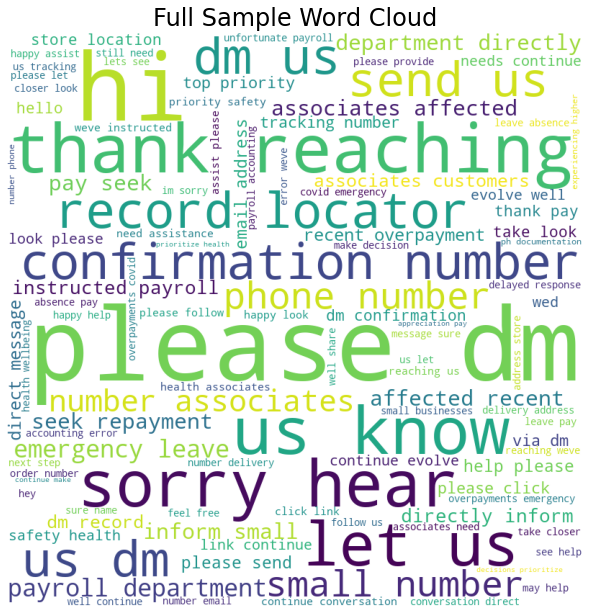

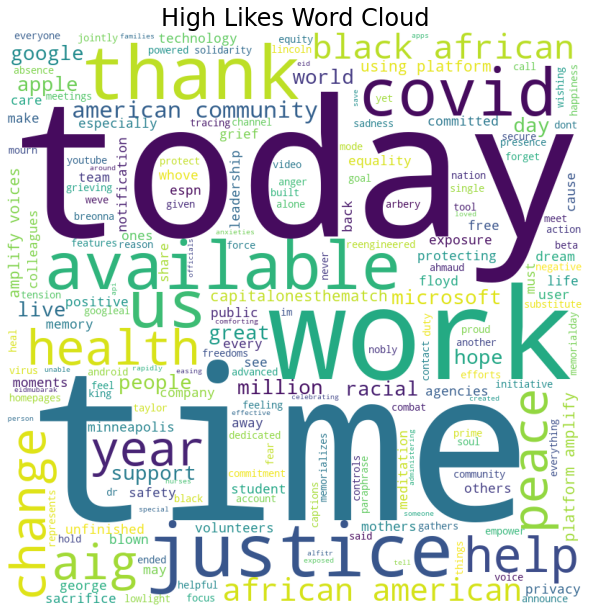

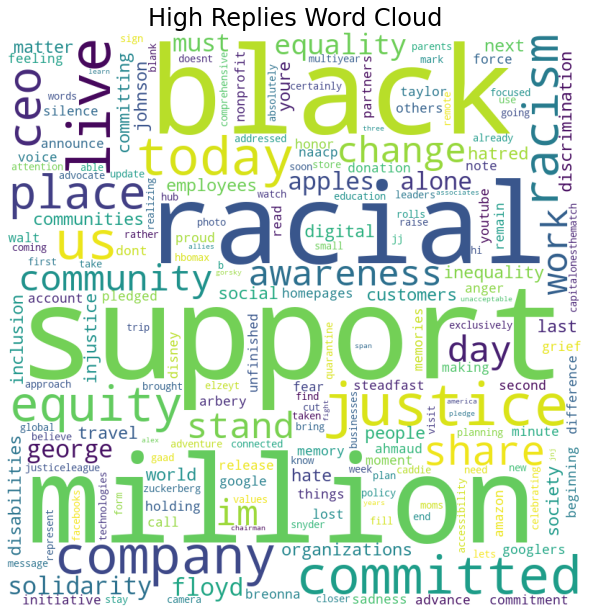

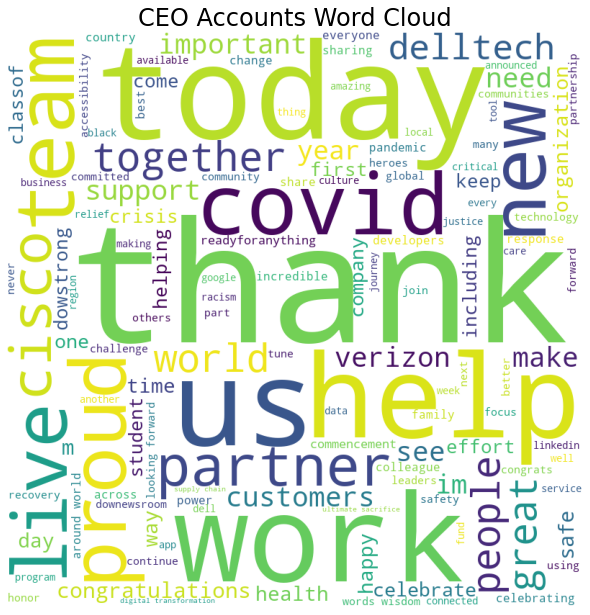

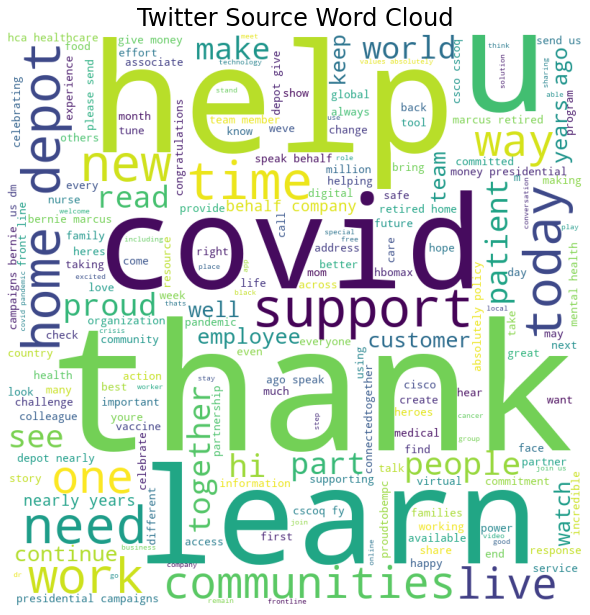

In [27]:
from nb_functions import plot_cloud

plot_cloud(full_sample_wc, "Full Sample Word Cloud")
plot_cloud(high_likes_wc, "High Likes Word Cloud")
plot_cloud(high_replies_wc, "High Replies Word Cloud")
plot_cloud(ceo_accounts_wc, "CEO Accounts Word Cloud")
plot_cloud(twitter_source_wc, "Twitter Source Word Cloud")


From a quick sentiment analysis, we can see that the tweets are mostly positive in tone. On average, tweets from CEO accounts are the most positive in tone, while tweets that receive a large number of replies tend to be essentially neutral in tone and less subjective than other tweets.

In [40]:
def return_sntmt(string):
    sntmt = TextBlob(string)
    return sntmt.sentiment.polarity, sntmt.sentiment.subjectivity

print(f'The full sample polarity is {return_sntmt(full_sample_string)[0]} and subjectivity is {return_sntmt(full_sample_string)[1]}.')
print(f'The high likes sample polarity is {return_sntmt(high_likes_string)[0]} and subjectivity is {return_sntmt(high_likes_string)[1]}.')
print(f'The high replies polarity is {return_sntmt(high_replies_string)[0]} and subjectivity is {return_sntmt(high_replies_string)[1]}.')
print(f'The CEO sample polarity is {return_sntmt(ceo_accounts_string)[0]} and subjectivity is {return_sntmt(ceo_accounts_string)[1]}.')
print(f'The Twitter source sample polarity is {return_sntmt(twitter_source_string)[0]} and subjectivity is {return_sntmt(twitter_source_string)[1]}.')

The full sample polarity is 0.17143327113075107 and subjectivity is 0.5235799143939149.
The high likes sample polarity is 0.14424064741228917 and subjectivity is 0.4441784583575629.
The high replies polarity is -0.011387686387686379 and subjectivity is 0.3486381673881674.
The CEO sample polarity is 0.27860169922669936 and subjectivity is 0.5362676521009859.
The Twitter source sample polarity is 0.2252232122241268 and subjectivity is 0.4953723580933319.


# NEXT STEP: LABELED TWEET ANALYSIS

> Start with brief descriptives, note that the flagged tweets are very rare occurrences. Look into weighting/etc. with sparse outcomes (perhaps compare to common situation where modelling default on loans). See C and your NLP exercise for the experiment for good start, and google visualizing text data in python. Perhaps use Bokeh for a graph or two

> Then go into training, validation, test split. Try a bunch of models, visualize performance, discuss diagnostics, etc.

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
